Started server on port 3787
{'camera.azimuth': 0, 'camera.altitude': 90, 'camera.target': [0, 0, 0], 'surface.{subject}.unfold': 1.0, 'surface.{subject}.pivot': 180, 'surface.{subject}.shift': 10, 'surface.{subject}.specularity': 0, 'surface.{subject}.sampler': 'nearest', 'surface.{subject}.layers': 1}
{'camera.azimuth': 180, 'camera.altitude': 90, 'camera.target': [0, 0, 0], 'surface.{subject}.unfold': 1.0, 'surface.{subject}.pivot': 180, 'surface.{subject}.shift': 10, 'surface.{subject}.specularity': 0, 'surface.{subject}.sampler': 'nearest', 'surface.{subject}.layers': 1}
Stopping server
Stopping server


/tmp/ipykernel_673084/2396226007.py:69: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.


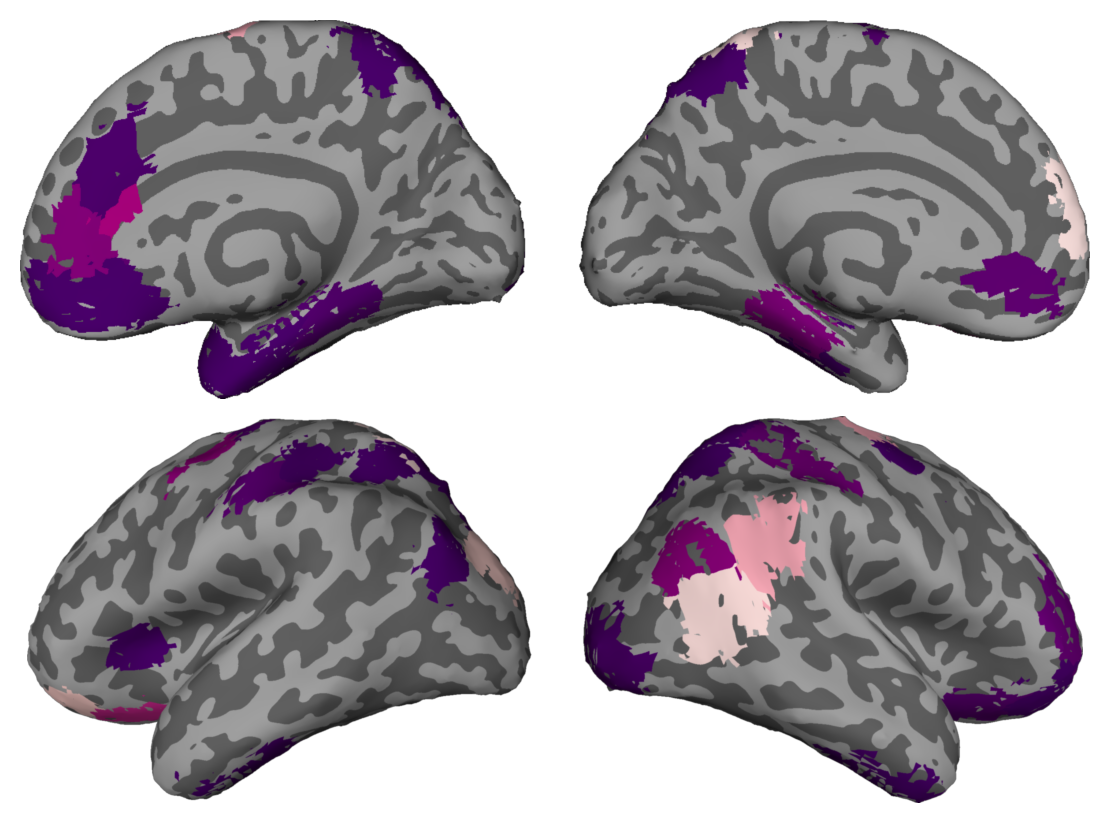

In [1]:
import os
import tempfile
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import cortex
import pickle
from statsmodels.stats.multitest import fdrcorrection
base_name = os.path.join(tempfile.mkdtemp(), 'fig')

num_rois = 200
Schaefer_atlas = nib.load(f"../utils/brain_atlas/Schaefer2018_cortical_{num_rois}_3mm.nii.gz").get_fdata()
#PU_RdBu_covar
model_positive_edges = np.load(f'data/BERT_based_model_positive_edges_{num_rois}_alt.npy')
model_negative_edges = np.load(f'data/BERT_based_model_negative_edges_{num_rois}_alt.npy')

r_statmap = np.zeros(Schaefer_atlas.shape)

for r in range(num_rois):
    r_1 = np.max([model_positive_edges[0,r], model_negative_edges[0,r]])
    if r_1>0.1:
        r_statmap[Schaefer_atlas==r+1] = r_1
r_statmap[r_statmap<0.1] = np.nan

cmax = 1.0
cmin = 0.0

cmap = 'RdPu'
cmap_label = 'Edge selection'
vol_data = cortex.Volume(r_statmap.transpose(2,1,0), 'MNI152', 'fmriprep',
                         cmap=cmap, colorbar=True, vmax=cmax, vmin=cmin)

filenames = cortex.export.save_3d_views(
                vol_data, base_name=base_name,
                list_angles=['medial_pivot', 'lateral_pivot'], #medial_pivot or lateral_pivot
                list_surfaces=['inflated', 'inflated'],
                size=(1024 * 4, 768 * 2), trim=True,)

fig = plt.figure(constrained_layout=True, dpi=200, figsize=(6,4))
gs = fig.add_gridspec(2, 1, height_ratios=[4.95, 5.05])

ax1 = fig.add_subplot(gs[0])
ax1.imshow(plt.imread(filenames[0]), interpolation='gaussian')
ax1.axis('off')

#create custom cmap
draw_cax = False
if draw_cax:
    cax = fig.add_axes([0.437, 0.515, 0.15, 0.03])
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack((gradient, gradient))
    cax.imshow(gradient, aspect='auto', cmap=cmap)
    pos = list(cax.get_position().bounds)
    x_text_left = pos[0] - 0.01
    x_text_center = pos[0] + pos[2]/2.
    x_text_right = pos[0] + pos[2] + 0.01
    y_text = pos[1] + pos[3]/2.
    y_text_bottom = pos[1] - 0.01
    fig.text(x_text_left, y_text, '{:0.2f}'.format(cmin), va='center', ha='right', fontsize=7)
    fig.text(x_text_right, y_text, '{:0.2f}'.format(cmax), va='center', ha='left', fontsize=7)
    fig.text(x_text_center, y_text_bottom, cmap_label, va='top', ha='center', fontsize=7)
    cax.axis('off')

ax2 = fig.add_subplot(gs[1])
ax2.imshow(plt.imread(filenames[1]), interpolation='gaussian')
ax2.axis('off')
plt.subplots_adjust(hspace=0.01)